  Author: Ankit Kariryaa, University of Bremen
  
  Modified by Xuehui Pi and Qiuqi Luo

### Getting started
Define the paths for the dataset and trained models in the `notebooks/config/UNetTraining.py` file.  

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = '16'
os.environ["NUMEXPR_NUM_THREADS"] = '16'
os.environ["OMP_NUM_THREADS"] = '16'
print(os.environ.get('OMP_NUM_THREADS'))

16


In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision 
mixed_precision.set_global_policy('mixed_float16')

import tensorflow as tf

import imageio
import os

import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet  #
from core.losses import tversky, focalTversky, bce_dice_loss, accuracy, dice_loss, IoU, recall, precision
from tensorflow.keras.losses import BinaryCrossentropy as bce
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.visualize import display_images,plot
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import shutil
import pickle
import random

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon
#matplotlib.use("Agg")

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(tf.__version__)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
2.9.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto(
    #device_count={"CPU": 64},
    allow_soft_placement=True, 
    log_device_placement=False)
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/UNetTraining.py)
# Please provide required info in the file before continuing with this notebook. 
# hbh: in this scene,a new config named UNetTraining_sequential is created to distinguish from the original
from config import UNetTraining_sequential
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import UNetTraining
config = UNetTraining_sequential.Configuration()

In [6]:
def readBands(path_to_write,fn):
    img=rasterio.open(os.path.join(path_to_write,fn))
#     im=img.read()
#     axis=(0, 1)
#     read_img=(im - im.mean(axis)) / (im.std(axis) + 1e-8)
    read_img=img.read()/1000
    return read_img

def readImgs(path_to_write, fn):
    NDWI_img = rasterio.open(os.path.join(path_to_write, fn))
    read_NDWI_img = NDWI_img.read()/100
#    read_green_img =readBands(path_to_write,fn.replace(config.NDWI_fn ,config.green_fn)),read_green_img
    read_swir_img = readBands(path_to_write, fn.replace(config.NDWI_fn ,config.swir_fn))
    comb_img = np.concatenate((read_NDWI_img, read_swir_img), axis=0)
    comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end  ( , ,1) 
    
    annotation_im = Image.open(os.path.join(path_to_write, fn.replace(config.NDWI_fn,config.annotation_fn)))
    annotation = np.array(annotation_im)
    
    f = FrameInfo(comb_img, annotation)
    return f

def readFrames(dataType):
    frames=[]
    print(dataType)
    for i in range(0,config.type_num):
        path_to_write=os.path.join(config.dataset_dir,'{}/type{}'.format(dataType,i))
        all_files = os.listdir(path_to_write)
        all_files_NDWI = [fn for fn in all_files if fn.startswith(config.NDWI_fn) and fn.endswith(config.image_type)]#ndwi.png
        print('type{} image number:{}'.format(i,len(all_files_NDWI)))
        for j, fn in enumerate(all_files_NDWI):
            f = readImgs(path_to_write,fn)
            frames.append(f)
    random.shuffle(frames)
    return frames

In [ ]:
frames=readFrames('train')
print('total training img count:'+str(len(frames)))
train_patches = DataGenerator(config.input_image_channel, config.patch_size, frames, config.input_label_channel, augmenter = 'iaa').all_sequential_patches(config.step_size)
print('train patchs number:',len(train_patcehs[0]))
frames=[]
frames=readFrames('val')
print('total validation img count:'+str(len(frames)))
val_patches = DataGenerator(config.input_image_channel, config.patch_size, frames, config.input_label_channel, augmenter = None).all_sequential_patches(config.step_size)
print('train patchs number:',len(val_patches[0]))
print('done')
frames=[]

train
type0 image number:129
type1 image number:108
type2 image number:52
type3 image number:41
total training img count:330


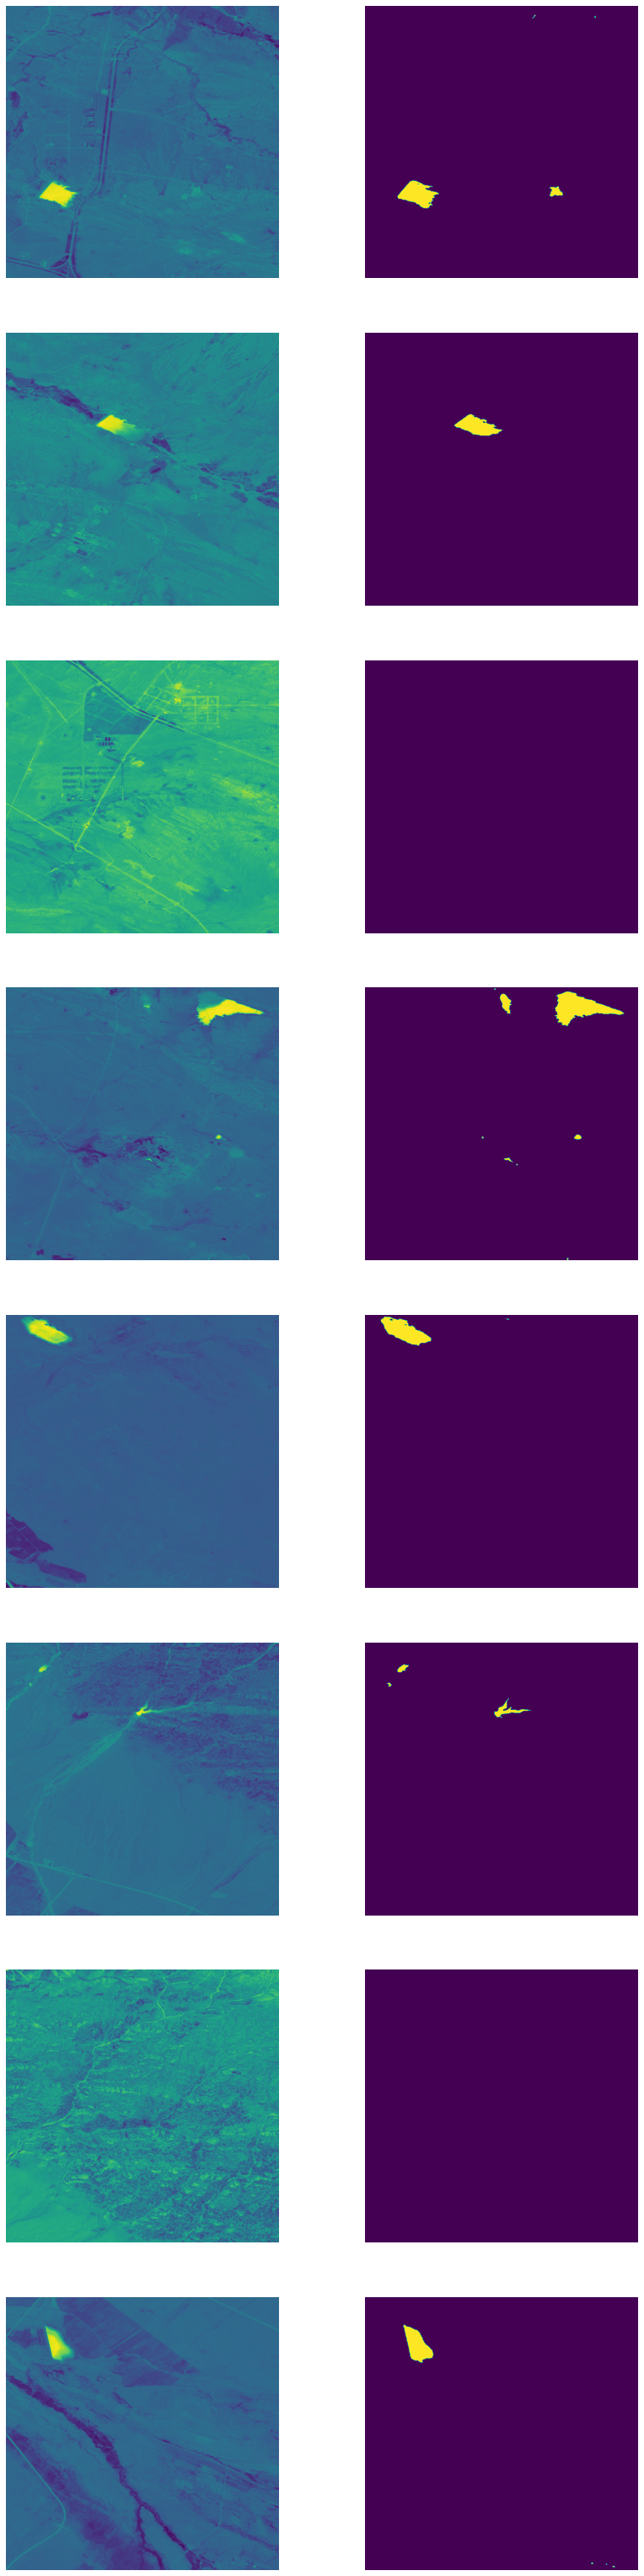

In [20]:
i=35
display_images(np.concatenate((train_patcehs[0][i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE],train_patcehs[1][i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE]), axis = -1))

(8, 1024, 1024, 1)


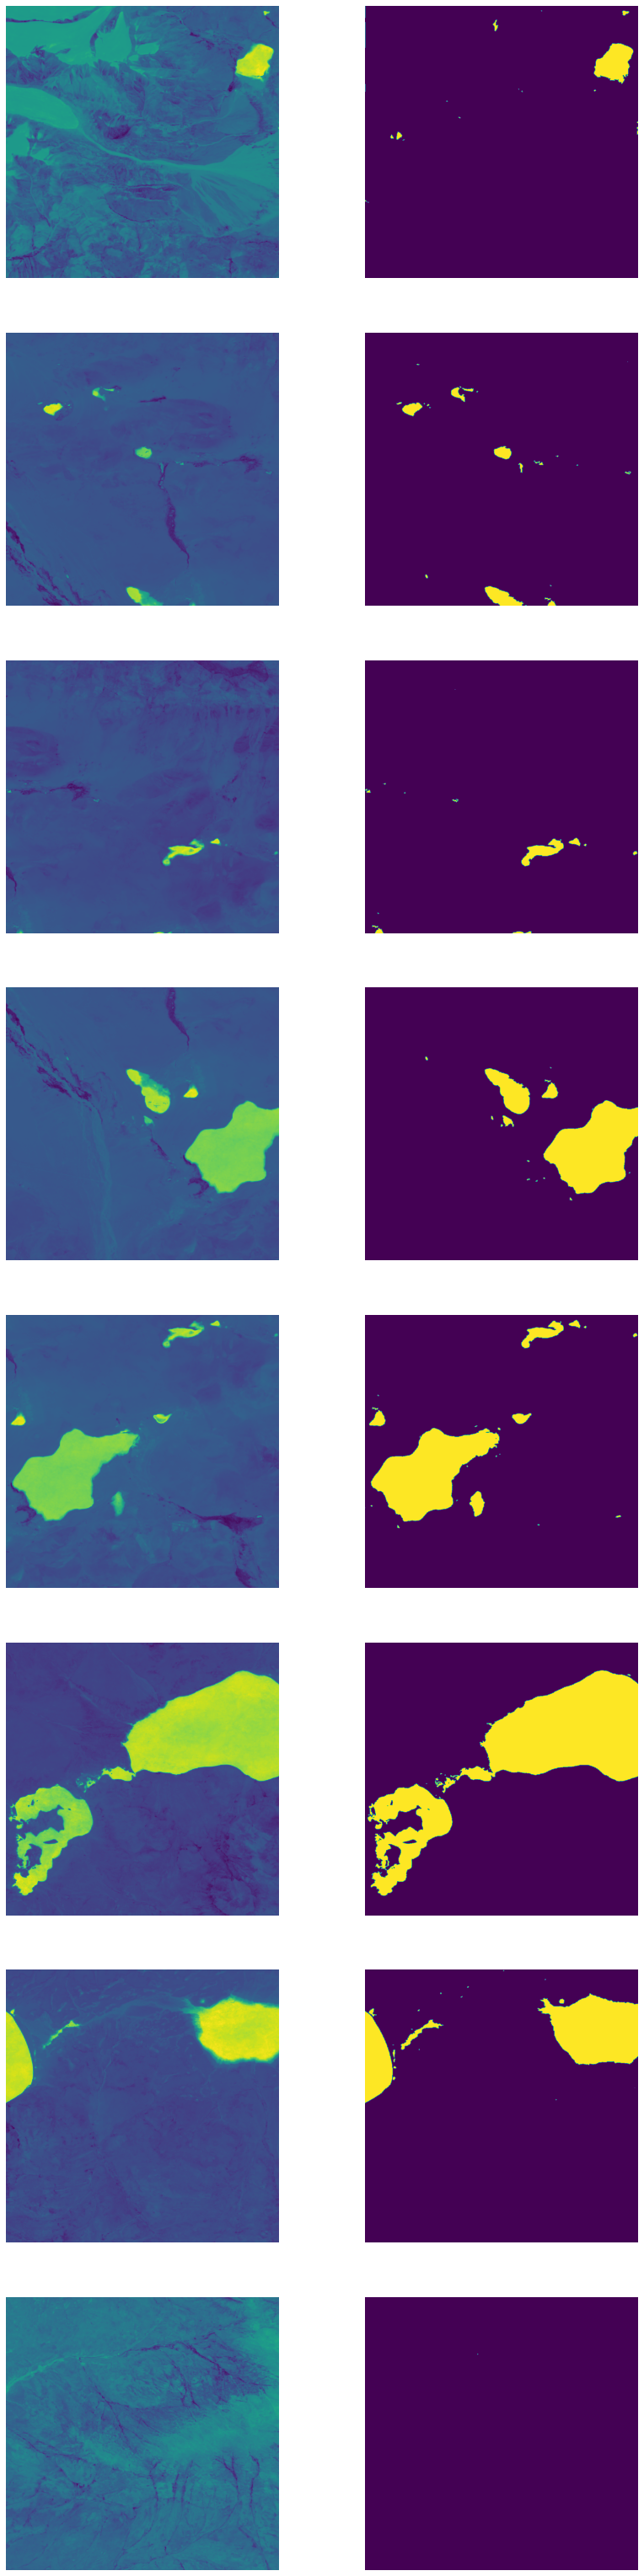

In [14]:
i=0
print(test_ann[i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE].shape)
display_images(np.concatenate((val_patches[0][i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE],val_patches[1][i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE]), axis = -1))

In [ ]:
# i=13
# display_images(np.concatenate((test_patches[0][i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE],test_patches[1][i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE]), axis = -1))

In [16]:
OPTIMIZER = adaDelta
OPTIMIZER = mixed_precision.LossScaleOptimizer(OPTIMIZER)
OPTIMIZER_NAME = 'AdaDelta'

# OPTIMIZER = adam
# OPTIMIZER = mixed_precision.LossScaleOptimizer(OPTIMIZER)
# OPTIMIZER_NAME = 'adam'

Instructions for updating:
Use tf.keras.mixed_precision. There is a guide at https://www.tensorflow.org/guide/mixed_precision. Alternatively, `tf.compat.v1.mixed_precision.enable_mixed_precision_graph_rewrite` can be used, but this is not recommended for TF2 code.
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)


In [25]:
# LOSS = tversky 
# LOSS_NAME = 'tversky'

# LOSS=focalTversky
# LOSS_NAME = 'focalTversky'

#LOSS=tf.keras.losses.BinaryCrossentropy()
#LOSS_NAME = 'bce'

# LOSS=bce_dice_loss
# LOSS_NAME = 'bce_dice_loss'

LOSS=dice_loss
LOSS_NAME = 'dice_loss'

semantic loss functions initialized


In [17]:
timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '') 

if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_name='_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0])
model_path = os.path.join(config.model_path,'lakes'+model_name)

chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '') 
print(model_path)

G:\U-Net\U-Net_7\saved_models/UNet\lakes_20230428-2135_AdaDelta_bce_01_512_new_lr001.h5


In [18]:
# Define the model and compile it  
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_loss, accuracy, recall, precision, IoU])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
# Define callbacks      for the early stopping of training, LearningRateScheduler and model checkpointing 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea： It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience 个epoch, reduce by a factor of 0.33, new_lr = lr * factor). 
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced. 

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16) 

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=20)


log_dir = os.path.join('./logs','UNet'+model_name)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard, early] #reduceLROnPlat is not required with adaDelta

In [20]:
#sequential stratergy
loss_history = model.fit(train_patches[0], train_patches[1], 
                         steps_per_epoch=len(train_patches[0])//config.BATCH_SIZE,
                         epochs=config.NB_EPOCHS, 
                         validation_data=val_patches,
                         validation_steps=len(val_patches[0])/config.BATCH_SIZE,
                         callbacks=callbacks_list,
                         workers=1,
                         shuffle=True
#                          use_multiprocessing=True # the generator is not very thread safe 
                         #max_queue_size = 60,
                        )
h=loss_history.history
with open('history_{}_{}_{}{}_{}_{}.txt'.format(OPTIMIZER_NAME,LOSS_NAME,config.input_shape[0], config.NB_EPOCHS, config.BATCH_SIZE,chs), 'wb') as file_pi:
    pickle.dump(h, file_pi)
plot(h, OPTIMIZER_NAME,LOSS_NAME, config.patch_size[0], config.NB_EPOCHS, config.BATCH_SIZE,chs)

Epoch 1/200
182/182 [==============================] - 212s 807ms/step - loss: 0.1571 - dice_coef: 0.6457 - dice_loss: 0.3543 - specificity: 0.9779 - sensitivity: 0.8116 - accuracy: 0.9570 - mIoU: 0.7170 - val_loss: 0.1231 - val_dice_coef: 0.6871 - val_dice_loss: 0.3129 - val_specificity: 0.9903 - val_sensitivity: 0.8201 - val_accuracy: 0.9773 - val_mIoU: 0.8076

Epoch 00001: val_loss improved from inf to 0.12308, saving model to G:\U-Net\U-Net_7\saved_models/UNet\lakes_20230428-2135_AdaDelta_bce_01_512_new_lr001.h5
Epoch 2/200
182/182 [==============================] - 146s 802ms/step - loss: 0.0671 - dice_coef: 0.8275 - dice_loss: 0.1725 - specificity: 0.9877 - sensitivity: 0.9077 - accuracy: 0.9772 - mIoU: 0.8234 - val_loss: 0.0475 - val_dice_coef: 0.8645 - val_dice_loss: 0.1355 - val_specificity: 0.9883 - val_sensitivity: 0.8972 - val_accuracy: 0.9857 - val_mIoU: 0.8759

Epoch 00002: val_loss improved from 0.12308 to 0.04747, saving model to G:\U-Net\U-Net_7\saved_models/UNet\lakes

KeyboardInterrupt: 

In [ ]:
# 读取现有history文件
h=loss_history.hist
# print(h)
with open('trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(h, file_pi)

In [37]:
plot(h, OPTIMIZER_NAME,LOSS_NAME, config.patch_size[0], config.NB_EPOCHS, config.BATCH_SIZE,chs)

In [ ]:
model_path=r'D:\lakemapping\U_Net\saved_models\UNet\lakes_20231105-1600_AdaDelta_dice_loss_0123_512.h5'
model = load_model(model_path, custom_objects={'dice loss': LOSS, 'accuracy':accuracy ,'recall':recall, 'precision':precision,'IoU': IoU}, compile=False) 
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_loss, accuracy,recall, precision, IoU])

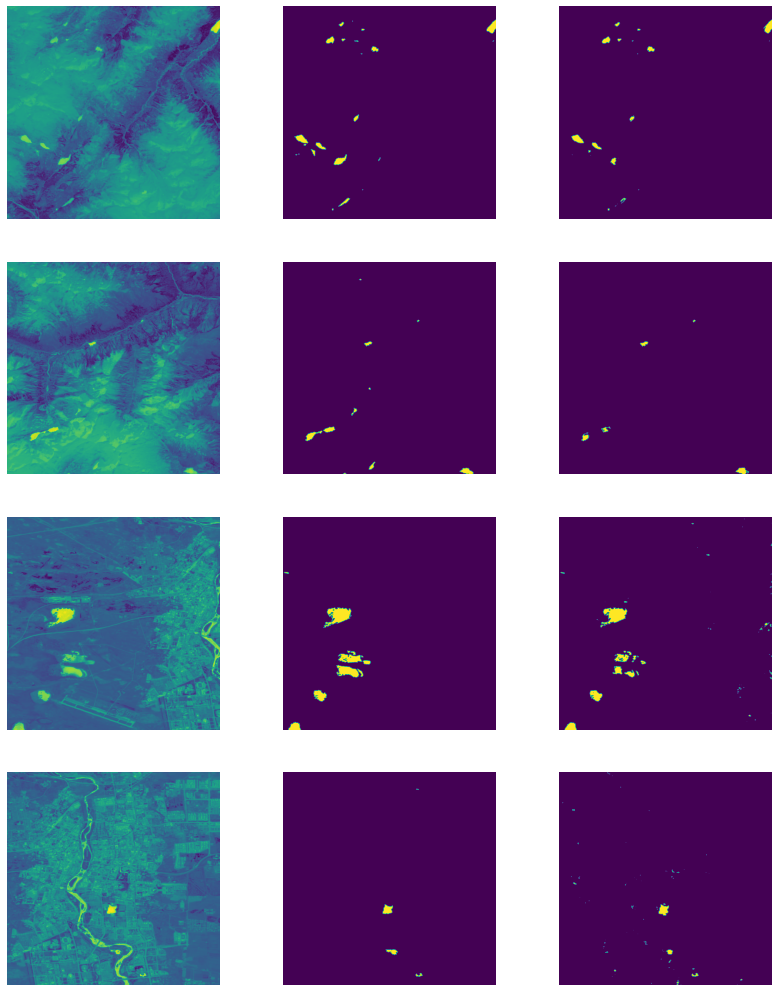

In [31]:
#3 images per row: NDWI, label, predition
i=30
test_img_l=test_img[i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE]
test_ann_l=test_ann[i*config.BATCH_SIZE:i*config.BATCH_SIZE+config.BATCH_SIZE]
prediction = model.predict(test_img_l, steps=1)
prediction[prediction>0.5]=1
prediction[prediction<=0.5]=0
display_images(np.concatenate((test_img_l, test_ann_l, prediction), axis = -1))# test_images( NDWI), real_label(label), prediction

In [32]:
model.evaluate(test_img,test_ann,config.BATCH_SIZE)

48/48 [==============================] - 10s 194ms/step - loss: 0.1638 - dice_coef: 0.8370 - dice_loss: 0.1630 - specificity: 0.9867 - sensitivity: 0.8330 - accuracy: 0.9789 - mIoU: 0.7658


[0.16377639770507812,
 0.8369877934455872,
 0.16301096975803375,
 0.9867379069328308,
 0.832977831363678,
 0.9789053201675415,
 0.7658014297485352]

In [ ]:
%tensorboard --logdir logs